In [1]:
import sys
import os
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../../"))

In [2]:
import torch
import os
import csv
import math
import random
import numpy as np
import scipy as sp
from itertools import permutations

In [3]:
from amore.models.cde.cde_data_common import process_data,get_final_linear_input_channels,get_final_indices,wrap_data,augment_data
import amore.models.cde.cde_train_common as train_common
import amore.models.cde.cde_data_common as cde_data_common
import amore.models.cde as cde

import amore.explainer.rule_pattern_miner as rlm
import amore.explainer.explainer_utils as eutils
from amore.explainer.FPGrowth_tree import *
import amore.explainer.itemsets_miner as itm

ModuleNotFoundError: No module named 'models'

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
import seaborn as sns

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree,export_text,export_graphviz
import amore.explainer.DT_rules as dtr
from amore.explainer.DT_rules import obtain_rule_lists_from_DT,select_rule_list

In [6]:
import urllib
import zipfile

def download(save_path):

    loc_Azip = os.path.join(save_path, 'training_setA.zip')
    loc_Bzip = os.path.join(save_path, 'training_setB.zip')
    
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    if not os.path.exists(loc_Azip):
        
        urllib.request.urlretrieve('https://archive.physionet.org/users/shared/challenge-2019/training_setA.zip',
                                   str(loc_Azip))
        urllib.request.urlretrieve('https://archive.physionet.org/users/shared/challenge-2019/training_setB.zip',
                                   str(loc_Bzip))

        with zipfile.ZipFile(loc_Azip, 'r') as f:
            f.extractall(str(save_path))
        with zipfile.ZipFile(loc_Bzip, 'r') as f:
            f.extractall(str(save_path))
        for folder in ('training', 'training_setB'):
            for filename in os.listdir(os.path.join(save_path,folder)):
                if os.path.exists(os.path.join(save_path,filename)):
                    raise RuntimeError
                os.rename(os.path.join(save_path, folder, filename), os.path.join(save_path, filename))

 

In [7]:
def new_make_model():
    model, regularise = make_model()
    model.linear.weight.register_hook(lambda grad: 100 * grad)
    model.linear.bias.register_hook(lambda grad: 100 * grad)
    return model, regularise

def group_processed_data(X,y,times):
    X = torch.tensor(X)
    y = torch.tensor(y)
    final_indices,_ = get_final_indices(times,y)
    coeffs = process_data(times,X,intensity=intensity,time_intensity=time_intensity,cummean=cummean,cumsum=cumsum,append_times=append_times,interpolate=interpolate)
    return coeffs,y,final_indices

In [8]:
## Control randomness for reproducibility

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [9]:
### Specify data path and results path
dpath = "./data/"
if not os.path.exists(dpath):
    os.mkdir(dpath)

data_folder = os.path.join(dpath,"sepsis")

rpath = "../results/sepsis"
if not os.path.exists(rpath):
    os.mkdir(rpath)
    

model_path = "./model"
if not os.path.exists(model_path):
    os.mkdir(model_path)

## Set model configurations

In [10]:
model_name = "ncde"

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [11]:
## Configuration of NCDE model

interpolate = "linear"    
side_input = False
concat_z = True

append_times = False
time_intensity = True
intensity = True 
static_intensity = True


time_len = 72
max_epochs = 100
pos_weight = 20

hidden_channels = 2 
hidden_hidden_channels = 128
num_hidden_layers = 4

batch_size = 1024
max_epochs = 500
lr = 0.0001 * (batch_size / 64)

num_classes = 2
cummean = True
cumsum = False


## Load and preprocess data

In [12]:
### Download data if not downloaded yet ###
if not os.path.exists(data_folder):     
    download(data_folder)

In [13]:
## Read raw data

X_times = []
X_static = []
y = []
H = time_len
for filename in os.listdir(data_folder):
    if filename.endswith('.psv'):
        with open(os.path.join(data_folder,filename)) as file:
            time = []
            label = 0.0
            reader = csv.reader(file, delimiter='|')
            reader = iter(reader)
            next(reader)  # first line is headings
            prev_iculos = 0
            for line in reader:
                assert len(line) == 41
                # time values are 34 features
                *time_values, age, gender, unit1, unit2, hospadmtime, iculos, sepsislabel = line
                iculos = int(iculos)
                #print('iculos',iculos)
                if iculos > H:  # keep at most the first H hours
                    break
                ## padding nan for missing hours
                for iculos_ in range(prev_iculos + 1, iculos):
                    time.append([float('nan') for value in time_values])
                    #time.append(np.zeros(len(time_values))+np.nan)
                prev_iculos = iculos
                time.append([float(value) for value in time_values])
                label = max(label, float(sepsislabel))
            unit1 = float(unit1)
            unit2 = float(unit2)
            unit1_obs = not math.isnan(unit1)
            unit2_obs = not math.isnan(unit2)
            if not unit1_obs:
                unit1 = 0.
            if not unit2_obs:
                unit2 = 0.
            hospadmtime = float(hospadmtime)
            if math.isnan(hospadmtime):
                hospadmtime = 0.  # this only happens for one record
            static = [float(age), float(gender), unit1, unit2, hospadmtime]
            if static_intensity:
                static += [unit1_obs, unit2_obs]
            if len(time) > 2:
                if len(time) < H:
                    # padding less hours
                    for t in range(H-len(time)):
                        time.append([float('nan') for value in time_values])
                X_times.append(time)
                X_static.append(static)
                y.append(label)
    

In [14]:
## preprocess data

times = np.arange(time_len).astype(np.float32)
times = torch.tensor(times)

X_times = np.array(X_times).astype(np.float32)
X_static = np.array(X_static).astype(np.float32)
y = np.array(y).astype(np.float32)


X_train,X_test,y_train,y_test = train_test_split(X_times,y,test_size=0.2,random_state=seed)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=seed)

### min-max normalization
for c in range(X_times.shape[-1]):
    mi = X_train[:,:,c][~np.isnan(X_train[:,:,c])].min()
    ma = X_train[:,:,c][~np.isnan(X_train[:,:,c])].max()
    X_train[:,:,c] = (X_train[:,:,c] - mi)/(ma - mi)+1.
    X_test[:,:,c] = (X_test[:,:,c] - mi)/(ma - mi)+1.
    X_val[:,:,c] = (X_val[:,:,c] - mi)/(ma - mi)+1.
    

In [15]:
## augment data with cumulative intensities and linear interploation

X_train_raw = augment_data(torch.tensor(X_train),times,intensity=intensity,time_intensity=time_intensity,cummean=cummean,cumsum=cumsum,append_times=append_times)
X_test_raw = augment_data(torch.tensor(X_test),times,intensity=intensity,time_intensity=time_intensity,cummean=cummean,cumsum=cumsum,append_times=append_times)
X_val_raw = augment_data(torch.tensor(X_val),times,intensity=intensity,time_intensity=time_intensity,cummean=cummean,cumsum=cumsum,append_times=append_times)

train_data = group_processed_data(X_train,y_train,times)
test_data = group_processed_data(X_test,y_test,times)
val_data = group_processed_data(X_val,y_val,times)

check X torch.Size([32266, 72, 136])
check X torch.Size([4033, 72, 136])
check X torch.Size([4034, 72, 136])


## Train or load the model

In [16]:
## Define the NCDE model

input_channels = train_data[0][0].shape[-1]
output_channels = 1
stream = True if concat_z else False

if concat_z or side_input:
    side_input_dim = cv_sets[0][0][-1].shape[-1] if side_input else 0
    final_linear_input_channels = get_final_linear_input_channels(hidden_channels,side_input_dim=side_input_dim,time_len=time_len)
else:
    final_linear_input_channels = None

make_model = train_common.make_model(model_name, input_channels, output_channels, hidden_channels,
                               hidden_hidden_channels, num_hidden_layers, use_intensity=False,
                              final_linear_input_channels=final_linear_input_channels, 
                              initial=True,side_input=side_input,append_times=append_times,interpolate=interpolate)


In [17]:
## train the model if no trained model available 
name = "sepsis_"+model_name + "_" + str(seed)
if not os.path.exists(model_path):
    times, train_dataloader, val_dataloader, test_dataloader = wrap_data(times, train_data, val_data, test_data, device,
                                                                                        batch_size=batch_size,num_workers=0)

    model,log,log_num = train_common.main(name, times, train_dataloader, val_dataloader, test_dataloader, device,
                       new_make_model, num_classes, max_epochs, lr, kwargs={'stream':stream}, pos_weight=torch.tensor(pos_weight),
                       step_mode=True,rpath=model_path)
    model.to('cpu')
    model.eval()
else:
    # load model if already trained and saved it
    log_num = 0 #change to the model number that need to be loaded
    model_loc = os.path.join(model_path,name,"model_"+str(log_num)) 
    if os.path.exists(model_loc):
        model, regularise_parameters = make_model()
        model.load_state_dict(torch.load(model_loc))
        model.to('cpu')
        model.eval()

interpolate linear


In [18]:
## get feature names of augmented features

raw_feature_names = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2',
                    'AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium',
                    'Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

latent_feature_names = [r'$z_'+str(i)+'(t_{'+str(h)+'})$' for h in range(time_len) for i in range(hidden_channels) ]
intensity_feature_names = [rf+'_ctime' for rf in raw_feature_names] + [rf+'_cmax' for rf in raw_feature_names] + [rf+'_cmean' for rf in raw_feature_names] 
input_feature_names = raw_feature_names + intensity_feature_names
feature_types = ["int" if "ctime" in fn else "float" for fn in input_feature_names] 
len(input_feature_names)

136

## Feature selection for AMORE

In [19]:
## get baseline and test samples for computing impact score matrix

model.append_times=append_times
train_reps = model.latent_representation(X_train_raw,times=times).detach()
test_reps = model.latent_representation(X_test_raw,times=times).detach()
val_reps = model.latent_representation(X_val_raw,times=times).detach()

baselines = eutils.gen_intgrad_baselines(X_train_raw,y_train,train_reps)
subset = eutils.gen_balanced_subset(X_train_raw,y_train,size_per_class=int(y_train.sum()))

In [20]:
## get impact score matrix of latent states
int_g, z_shift = [], []
for c in range(2):
    int_g_c, z_shift_c = eutils.calc_baselines_intg(test_examples=subset,model=model,baselines=baselines,times=times,target_c=c,target_dim=0,C=2)
    int_g.append(int_g_c)
    z_shift.append(z_shift_c)

int_g = torch.vstack(int_g)
z_shift = torch.vstack(z_shift)

In [21]:
## get predicted probability of training, test, and validation sets

linear_prams = []
for p in model.linear.parameters():
    p = p.detach()
    linear_prams.append(p)

pred_y_train = model.linear(train_reps.reshape(train_reps.shape[0],-1)).detach().numpy()
pred_y_test = model.linear(test_reps.reshape(test_reps.shape[0],-1)).detach().numpy()

In [22]:
## get prediction threshold by roc

pred_y = sp.special.expit(pred_y_train).reshape(-1)
auc = roc_auc_score(y_train, pred_y)
fpr, tpr, thresholds = roc_curve(y_train, pred_y)
y_thd = thresholds[np.argmax(tpr - fpr)]
print("y threshold",y_thd)

y threshold 0.5414686


In [23]:
## AUC on test set
auc = roc_auc_score(y_test, pred_y_test)
auc

0.8441754285578046

In [24]:
# # If test the rule extraction methods for multiple random seeds, change the random seed here.
# # If change random seed in the begining, the model, the training, and test set will change as well, the randomness will have several sources.

# seed = 0
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

In [25]:
## get impact score matrix for output

C=2  ## two classes
baseline_reps = model.latent_representation(baselines,times=times)
baseline_output = model.linear(baseline_reps.reshape(baseline_reps.shape[0],-1)).detach()

subset_reps,subset_output = [],[]
for k in range(C):
    subset_reps.append(model.latent_representation(subset[k],times=times))
    subset_output.append(model.linear(subset_reps[k].reshape(subset_reps[k].shape[0],-1)).detach())
    
cids = np.arange(C)
yshift = []
for k in cids:
    for kk in cids[cids!=k]:
        yshift.append(subset_output[k]-baseline_output[kk])
yshift = torch.vstack(yshift)

weights = linear_prams[0].reshape(-1,hidden_channels)
y_int_g = eutils.output_intg_score(int_g,weights,yshift)
y_int_g[torch.isnan(y_int_g)] = 0.

In [26]:
## get impact score threshold 
thds = np.linspace(0.01,0.2,200)
f_n = []
for thd in thds:
    mask = torch.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(dim=0)>=len(y_int_g)*0.99).sum()))
    if f_n[-1][1]==1:
        break
thd = f_n[-1][0]
thd

0.04055276381909548

In [27]:
## get frequent important feature set
itemsets_y = itm.transform_intgrad_to_itemsets(y_int_g,thd=thd)
fids = itm.gen_freq_feature_set(itemsets_y[0],min_support=100,max_len=500)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

feature set [8741 9693 6701 9285 7109 9557 7789 9149 8059 6565 8333 7515 6971 6291
 6837 7243 6970 8467 8058 7242 7653 9011 6290 8063 7381 8466 7519 7514
 7379 5746 7378 6157 8471 9010 5747 7651 6021 6973 6295 7925 8197 9696
 8330 8742 6698 7247 9015 6975 8331 5477 7786 5882 8336 9690 6699 7655
 7792 5749 8875 9694 5883 7110 8739 7654 5613 7650 8743 9286 5885 7383
 8195 7787 7112 9419 9418 5067 8061 8064 8874 5205 9150 5751 8199 8605
 4389 9560 8198 8879 4935 5071 6704 7790 4931 7384 6976 9558 5066 6427
 8194 6838 6562 9691 4525 5887 7248 8603 9423 7518 8335 6426 8470 7245
 6294 5474 7922 7106 8738 9692 5752 4930 6568 9554 8740 6703 8607 6563
 9287 5475 8472 8744 9288 4797 6431 8602 8334 7928 3981 9283 6839 4799
 7520 3573 8606 9016 9014 3165 9151 5888 9284 9152 9421 7923 4795 9147
 9424 9556 8878 6835 5069 7108 7791 9148 6296 4253 2893 6566 5480 9700
 4119 7116 5479 6160 8877 6158 7788 7652 4115 3029 9555 6022 5072 5207
 7246 8332 6840 7796 8196 6702 3845 8062 5341 6836 4794 5206 7926

## Extract rules by AMORE

In [29]:
x = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()

## set "grid_search = True" to do a grid search for hyperprameters

grid_search = True

if grid_search:
    ng_range = np.arange(2,11)
    bin_strategies = ["uniform","kmeans"]
    support_range = np.arange(1000,8000,1000)
    confidence_lower_bound = 0.8
    max_depth=2
    top_K=3


    best_rule_set,best_configs,config_metric_records = rlm.param_grid_search_for_amore(bin_strategies,ng_range,support_range,X=x,fids=fids,target_indices=(pred_y>y_thd),y=y_train,c=1,confidence_lower_bound=confidence_lower_bound,
                                                                                        max_depth=max_depth,top_K=top_K,sort_by="fitness")
    print(best_rule_set,best_configs)

grid search hyperparameters
{'rules': [(6154, '>=', 33.142857142857146), (5204, '>=', 33.57142857142857)], 'confidence': 0.8597678916827853, 'support': 2068, 'fitness': 0.20476124948396865, 'cond_prob_y': 0.23597678916827852, 'ratio_y': 0.27743035815804434} {'bin_strategy': 'uniform', 'num_grids': 7, 'min_support': 2000}


In [30]:
### search rules for target pattern: pred_y > y_thd  ###
### we set the hyperparameters obtaind by above grid search step ###
min_support=2000
num_grids=7
max_depth=2
bin_strategy="uniform"


y_rule_candidates = rlm.gen_rule_list_for_one_target(x,fids,pred_y>y_thd,y=y_train,c=1,sort_by="fitness",
                                                    min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=3,
                                                    local_x=None,feature_types=feature_types*time_len,bin_strategy=bin_strategy,
                                                    verbose=False,search="greedy")

In [31]:
feature_names = [f+"_t"+str(t) for t in range(time_len) for f in input_feature_names ]
for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],feature_names)
    y_rule_candidates[i] = rules
y_rule_candidates

[{'rules': [(6154, 'HR_ctime_t45', '>=', 34.0),
   (5204, 'Temp_ctime_t38', '>=', 34.0)],
  'confidence': 0.8597678916827853,
  'support': 2068,
  'fitness': 0.20476124948396865,
  'cond_prob_y': 0.23597678916827852,
  'ratio_y': 0.27743035815804434},
 {'rules': [(6154, 'HR_ctime_t45', '>=', 34.0),
   (5612, 'Temp_ctime_t41', '>=', 37.0)],
  'confidence': 0.8601161665053243,
  'support': 2066,
  'fitness': 0.20476124948396862,
  'cond_prob_y': 0.2362052274927396,
  'ratio_y': 0.27743035815804434},
 {'rules': [(6154, 'HR_ctime_t45', '>=', 34.0),
   (5476, 'Temp_ctime_t40', '>=', 36.0)],
  'confidence': 0.8601161665053243,
  'support': 2066,
  'fitness': 0.20476124948396862,
  'cond_prob_y': 0.2362052274927396,
  'ratio_y': 0.27743035815804434},
 {'rules': [(5338, 'HR_ctime_t39', '>=', 29.0),
   (7652, 'Temp_ctime_t56', '>=', 49.0)],
  'confidence': 0.8275024295432458,
  'support': 2058,
  'fitness': 0.1854960781615522,
  'cond_prob_y': 0.2371234207968902,
  'ratio_y': 0.2774303581580443

## Extract rules by Decision Tree

In [33]:
## set "grid_search = True" to do a grid search for hyperprameters for Decision Tree Classifier

X_tr = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()
X_tr[np.isnan(X_tr)] = 0.

if grid_search:

    criteria = ["gini", "entropy", "log_loss"]
    support_range = np.arange(1000,8000,1000)
    w = (pred_y>y_thd).sum()/pred_y.shape[0]
    class_weight_options = [{0:0.5,1:0.5},{0:1./(1.-w),1:1./w}]

    DT_best_rule_set, DT_best_configs, DT_config_metric_records = dtr.param_grid_search_for_DT(criteria,support_range,weight_options=class_weight_options,X=X_tr,y=y_train,target_indices=pred_y>y_thd,c=1,max_depth=max_depth,feature_names=feature_names,confidence_lower_bound=confidence_lower_bound,seed=seed)
    print(DT_best_rule_set, DT_best_configs)

{'rules': [(3029, '>', 9.5), (2892, '>', 18.5)], 'support': 2000, 'fitness': 0.19017476262556762, 'confidence': 0.8455} {'criterion': 'gini', 'min_support': 2000, 'class_weight': {0: 0.5, 1: 0.5}}


In [34]:
### Obtain rules for target pattern: pred_y > y_thd from a DecisionTreeClassifier ###
### We set the hyperparameters obtaind by above grid search step ###

criterion = "gini"
min_support = 2000
class_weight = {0: 0.5, 1: 0.5}


treemodel = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_support,random_state=seed,criterion=criterion,class_weight=class_weight)
treemodel.fit(X_tr,pred_y>y_thd)

DecisionTreeClassifier(class_weight={0: 0.5, 1: 0.5}, max_depth=2,
                       min_samples_leaf=2000, random_state=42)

In [35]:
print(export_text(treemodel))

|--- feature_3029 <= 9.50
|   |--- feature_9566 <= 70.50
|   |   |--- class: False
|   |--- feature_9566 >  70.50
|   |   |--- class: False
|--- feature_3029 >  9.50
|   |--- feature_2892 <= 18.50
|   |   |--- class: True
|   |--- feature_2892 >  18.50
|   |   |--- class: True



In [36]:
rule_list, rule_value_list, rule_metric_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,X_tr,y_train,pred_y>y_thd,np.arange(X_tr.shape[-1]),feature_names,c=1)

In [37]:
dtr.display_rules_from_DT(rule_list,rule_metric_list,feature_names)

#################
[(3029, '<=', 9.5), (9566, '<=', 70.5)]
confidence 0.295 cond_prob_y 0.059 support 13285 fitness -0.75
SBP_ctime_t22 <= 9.5
PaCO2_ctime_t70 <= 70.5
#################
[(3029, '<=', 9.5), (9566, '>', 70.5)]
confidence 0.021 cond_prob_y 0.016 support 14376 fitness -1.894
SBP_ctime_t22 <= 9.5
PaCO2_ctime_t70 > 70.5
#################
[(3029, '>', 9.5), (2892, '<=', 18.5)]
confidence 0.519 cond_prob_y 0.11 support 2605 fitness 0.014
SBP_ctime_t22 > 9.5
Temp_ctime_t21 <= 18.5
#################
[(3029, '>', 9.5), (2892, '>', 18.5)]
confidence 0.846 cond_prob_y 0.226 support 2000 fitness 0.19
SBP_ctime_t22 > 9.5
Temp_ctime_t21 > 18.5


### Below code is for plotting confidence and fitness while varying minimum support 

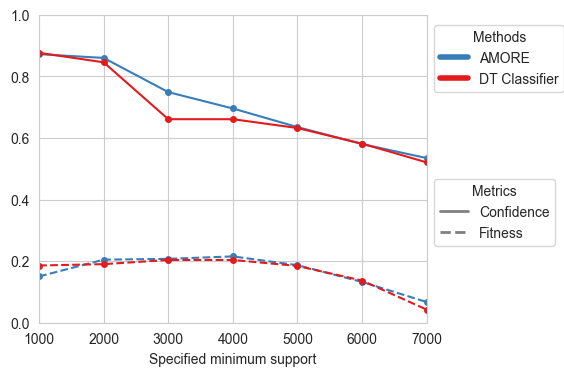

In [38]:
## Need grid search first to get the results with different minimum supports

if grid_search:
    
    cf_mtx = np.vstack([config_metric_records[key]["top_confidence_records"] for key in config_metric_records.keys()])
    ft_mtx = np.vstack([config_metric_records[key]["top_fitness_records"] for key in config_metric_records.keys()])
    
    DT_cf_mtx = np.vstack([DT_config_metric_records[key]["top_confidence_records"] for key in DT_config_metric_records.keys()])
    DT_ft_mtx = np.vstack([DT_config_metric_records[key]["top_fitness_records"] for key in DT_config_metric_records.keys()])
    
    eutils.plot_confidence_fitness_curve(cf_mtx,ft_mtx,DT_cf_mtx,DT_ft_mtx,support_range)